# Práctica Deep Learning - KeepCoding

## Predicción del precio de la vivienda en Airbnb
En esta práctica se nos pide predecir el precio de una vivienda de Airbnb basándonos por un lado en datos tabulares (1D) y por otro lado en imagenes de las habitaciones (2D) para luego hacer combinaciones entre las predicciones individuales con estrategias de combinación late-fusion y early-fusion.

Por ello, trabajaremos con dos grandes conjuntos de datos, por un lado con los datos tabulares que almacenaremos como dataframe y por otro con un conjunto de imagenes (vectores de dos dimensiones) que normalizaremos.

### 1. Importación de los datos
En primer lugar, se van a cargar los datos tabulares del fichero dataset.csv que cuenta con información a cerca de precios de airbnbs en Madrid. Una vez cargados los datos, eliminamos las filas que vengan con la variable objetivo Price vacía y hacemos una previsualización del dataset para conocer mejor que tipo de datos tenemos.

In [3]:
import cv2
import numpy
import pandas
import imageio.v3 as io
import matplotlib.pyplot as plt

from tqdm import tqdm
from typing import Optional, Union
data = pandas.read_csv("data/dataset.csv", sep = ';')
data = data.dropna(subset=['price'])
data.head()

,id,listing_url,scrape_id,last_scraped,source,picture_url,host_id,host_url,host_name,host_since,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,3781,https://www.airbnb.com/rooms/3781,20231218233145,2023-12-19,city scrape,https://a0.muscache.com/pictures/24670/b2de044...,4804,https://www.airbnb.com/users/show/4804,Frank,2008-12-03,...,4.96,4.88,4.92,NaN,f,1,1,0,0,0.23
1,5506,https://www.airbnb.com/rooms/5506,20231218233145,2023-12-19,city scrape,https://a0.muscache.com/pictures/miso/Hosting-...,8229,https://www.airbnb.com/users/show/8229,Terry,2009-02-19,...,4.89,4.55,4.75,STR-490093,f,10,10,0,0,0.68
2,6695,https://www.airbnb.com/rooms/6695,20231218233145,2023-12-19,city scrape,https://a0.muscache.com/pictures/38ac4797-e7a4...,8229,https://www.airbnb.com/users/show/8229,Terry,2009-02-19,...,4.95,4.51,4.71,STR-491702,f,10,10,0,0,0.73
3,8789,https://www.airbnb.com/rooms/8789,20231218233145,2023-12-19,city scrape,https://a0.muscache.com/pictures/miso/Hosting-...,26988,https://www.airbnb.com/users/show/26988,Anne,2009-07-22,...,4.96,4.96,4.56,NaN,f,9,9,0,0,0.24
4,10813,https://www.airbnb.com/rooms/10813,20231218233145,2023-12-19,city scrape,https://a0.muscache.com/pictures/20b5b9c9-e1f4...,38997,https://www.airbnb.com/users/show/38997,Michelle,2009-09-16,...,5.00,5.00,4.80,NaN,f,11,11,0,0,0.09


Tras una primera visualización vemos que los datos parecen estar algo sesgados a la ciudad de Boston. Por ello, vamos a sacar un gráfico para ver la cantidad de datos que vienen de esta ciudad.

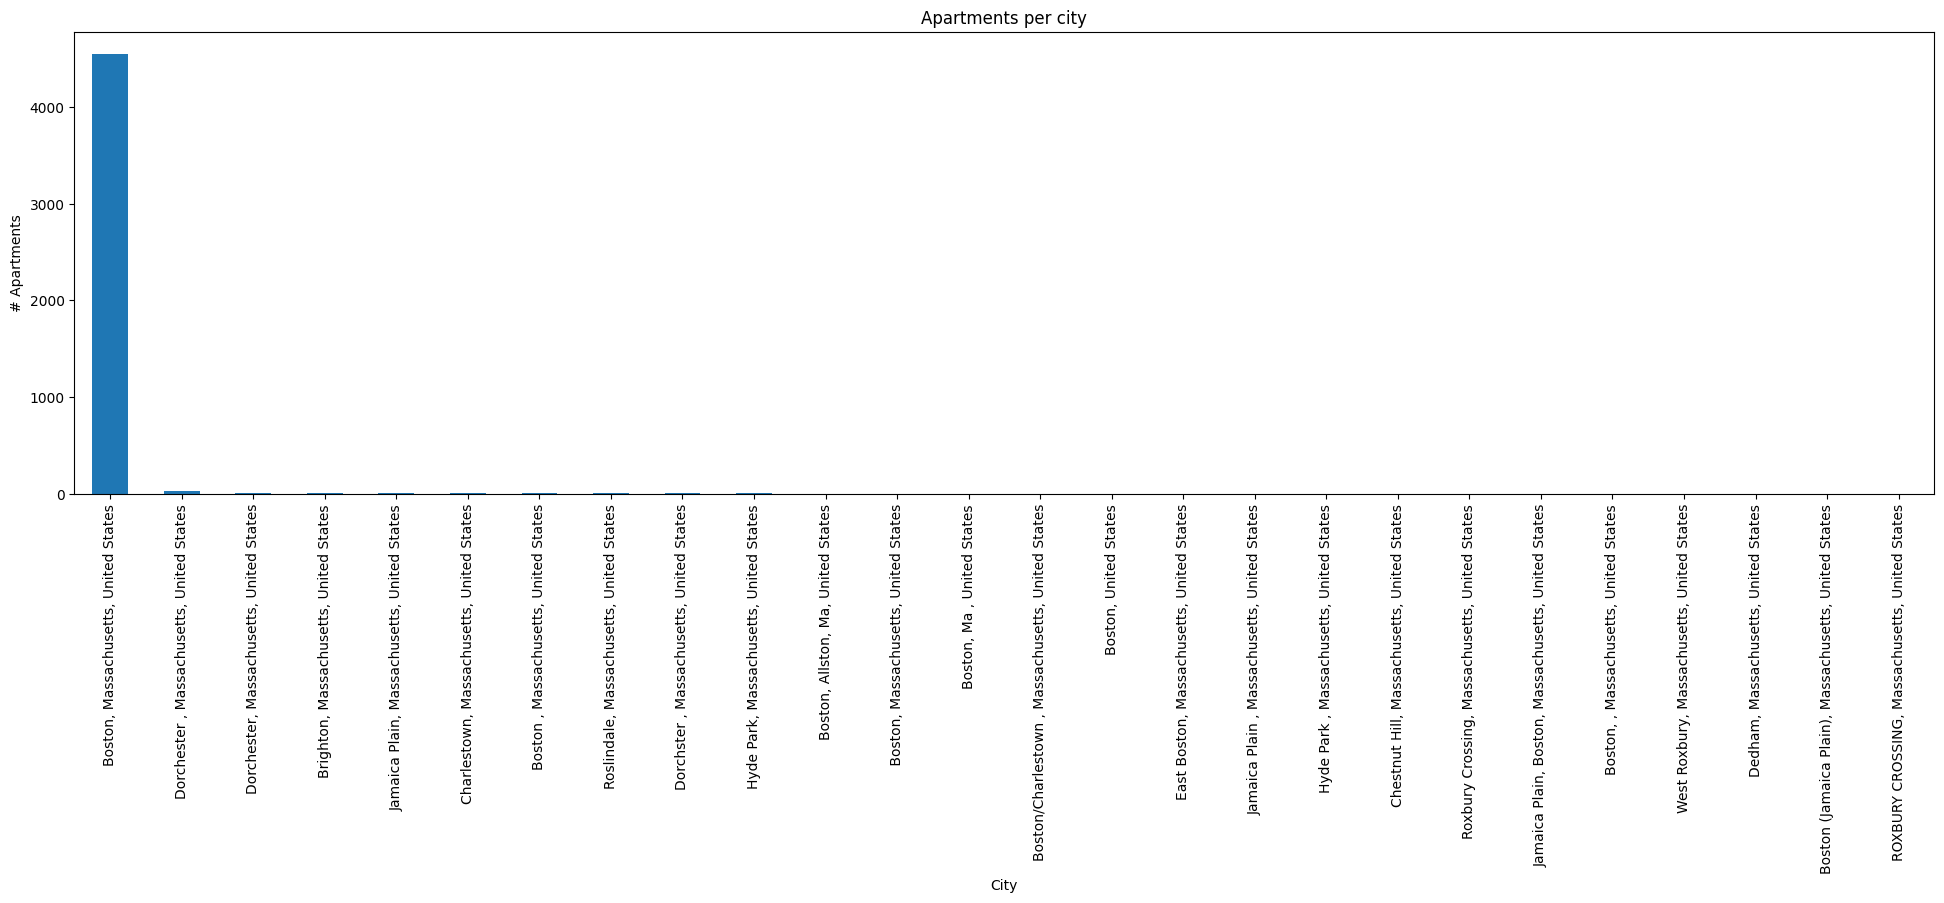

In [4]:
city_counts = data.neighbourhood.value_counts()
plt.figure(figsize=(24, 6))
city_counts.plot(kind='bar')
plt.title('Apartments per city')
plt.xlabel('City')
plt.ylabel('# Apartments')
plt.xticks(rotation=90)
plt.show()

Ya que la diferencia de datos en la ciudad de Boston es inmensamente mayor al resto de ciudades, vamos a seleccionar solo los registros de Boston, descartando así la variable `neighbourhood`

In [5]:
boston_data = data[data.neighbourhood == 'Boston, Massachusetts, United States']
boston_data.drop(columns='neighbourhood', axis=1, inplace=True)

<ipython-input-5-1532cbceddf9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boston_data.drop(columns='neighbourhood', axis=1, inplace=True)


Encontramos varios campos con URLs de descarga de imágenes, por ello, vamos a descargar primero estas imágenes y almacenarlas en una variable, obteniendo así el conjunto de datos necesario para la predicción 2D. Primero definimos la función para descarga de imágenes:

In [8]:

def download_images(paths: list,
                    canvas: tuple = (224, 224),
                    nb_channels: int = 3,
                    max_imgs: Optional[int] = None
                    ) -> tuple:
  """ Download a list of images from url adresses, converting them to a specific
  canvas size.

  Args:
    paths: Paths or url adresses from which to load images.
    canvas: Desired image width and height.
    nb_channels: Channels in images (1 for B/W, 3 for RGB).
    max_imgs: Upper threshold in the number of images to download.

  Return:
    a tuple of:
      - image values
      - indices within the paths that were successfull.

  """
  n_images = len(paths) if not max_imgs else max_imgs
  images = numpy.zeros((n_images, canvas[0], canvas[1], nb_channels),
                       dtype=numpy.uint8)
  downloaded_idxs = []

  for i_img, url in enumerate(tqdm(paths, total=n_images)):
    if i_img >= n_images:
      break
    try:
        img = io.imread(url)
        img = cv2.resize(img, (canvas[0], canvas[1]))
        downloaded_idxs.append(i_img)
        images[i_img] = img
    except (IOError, ValueError) as e:
        pass
  return images[downloaded_idxs], downloaded_idxs

A continuación, descargamos las imágenes y normalizamos valores para encajar entre 0 y 1:

In [12]:
images, idxs = download_images(boston_data['picture_url'])
images = images.astype("float32") / 255.
images.shape


100%|██████████| 4547/4547 [22:50<00:00,  3.32it/s]


(3723, 224, 224, 3)

A continuación, filtramos acorde en los demás datos para quedarnos solo las filas cuyas imágenes pudieron descargarse:

In [13]:
filtered_data = boston_data.iloc[idxs]
filtered_data

,id,listing_url,scrape_id,last_scraped,source,picture_url,host_id,host_url,host_name,host_since,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,3781,https://www.airbnb.com/rooms/3781,20231218233145,2023-12-19,city scrape,https://a0.muscache.com/pictures/24670/b2de044...,4804,https://www.airbnb.com/users/show/4804,Frank,2008-12-03,...,4.96,4.88,4.92,NaN,f,1,1,0,0,0.23
1,5506,https://www.airbnb.com/rooms/5506,20231218233145,2023-12-19,city scrape,https://a0.muscache.com/pictures/miso/Hosting-...,8229,https://www.airbnb.com/users/show/8229,Terry,2009-02-19,...,4.89,4.55,4.75,STR-490093,f,10,10,0,0,0.68
2,6695,https://www.airbnb.com/rooms/6695,20231218233145,2023-12-19,city scrape,https://a0.muscache.com/pictures/38ac4797-e7a4...,8229,https://www.airbnb.com/users/show/8229,Terry,2009-02-19,...,4.95,4.51,4.71,STR-491702,f,10,10,0,0,0.73
3,8789,https://www.airbnb.com/rooms/8789,20231218233145,2023-12-19,city scrape,https://a0.muscache.com/pictures/miso/Hosting-...,26988,https://www.airbnb.com/users/show/26988,Anne,2009-07-22,...,4.96,4.96,4.56,NaN,f,9,9,0,0,0.24
4,10813,https://www.airbnb.com/rooms/10813,20231218233145,2023-12-19,city scrape,https://a0.muscache.com/pictures/20b5b9c9-e1f4...,38997,https://www.airbnb.com/users/show/38997,Michelle,2009-09-16,...,5.00,5.00,4.80,NaN,f,11,11,0,0,0.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7189,1045997580495005942,https://www.airbnb.com/rooms/1045997580495005942,20231218233145,2023-12-19,city scrape,https://a0.muscache.com/pictures/prohost-api/H...,22348222,https://www.airbnb.com/users/show/22348222,Maverick,2014-10-09,...,NaN,NaN,NaN,STR-540399,t,87,87,0,0,NaN
7191,1046356755567106626,https://www.airbnb.com/rooms/1046356755567106626,20231218233145,2023-12-19,city scrape,https://a0.muscache.com/pictures/miso/Hosting-...,275849638,https://www.airbnb.com/users/show/275849638,Steven,2019-07-13,...,NaN,NaN,NaN,Exempt: This listing is a unit that has contra...,t,71,71,0,0,NaN
7192,1046470991404568874,https://www.airbnb.com/rooms/1046470991404568874,20231218233145,2023-12-19,city scrape,https://a0.muscache.com/pictures/miso/Hosting-...,365116307,https://www.airbnb.com/users/show/365116307,Healing Homes,2020-08-30,...,NaN,NaN,NaN,Exempt: This listing is a unit that has contra...,f,64,64,0,0,NaN
7193,1046490108856067836,https://www.airbnb.com/rooms/1046490108856067836,20231218233145,2023-12-19,city scrape,https://a0.muscache.com/pictures/miso/Hosting-...,365116307,https://www.airbnb.com/users/show/365116307,Healing Homes,2020-08-30,...,NaN,NaN,NaN,Exempt: This listing is a unit that has contra...,t,64,64,0,0,NaN


Ya que el descargado de imágenes es una tarea bastante lenta, vamos a almacenar esta matriz de imágenes normalizadas para su posterior uso:

In [14]:
numpy.save('data/images.npy', images)
filtered_data.to_csv('data/filtered_data.csv', sep=';', index=False)

Una vez guardados para futuras cargas, volvemos a importar los datos:

In [ ]:
data = pandas.read_csv("data/images.npy", sep=';')
images = numpy.load("data/filtered_data.csv")

### 2. Split de datos en train/validation/test
A continuación, se va a dividir el conjunto total de datos en subconjunto de train, validation y test. Posteriorimente procederemos con la limpieza de datos tabulares para poder empezar a entrenar los modelos.

Echando un primer vistazo a la información tabular otorgada, encuentro ciertas cosas curiosas que tendré en cuenta a la hora de seleccionar características:
- La variable `bedrooms` está vacía. A priori, diría que el número de habitaciones puede ser una de las características más influyentes en el precio de un airbnb, pero no contamos con esta información, por lo que tendrémos que basarnos en el número de camas y el número de personas que admite.
- La variable bathrooms también está vacía pero tenemos una variable bathrooms_text que nos indica el número de baños y el tipo de baño (privado o compartido) por ello, se crearán dos variables nuevas, una `bathrooms` indicando el número de baños y otra `bathroom_type` que indica qué tipo de baño se ofrece.
- Encontramos dos variables que hacen referencia al tipo de propiedad que se alquila, `property_type` y `room_type`. Teniendo en cuenta que son variables categóricas que tendremos que codificar, se va a elegir solo `room_type` para mayor comodidad y menor redundancia.
- Se han mantenido las variables latitude y longitude simplemente para generar un mapa de calor por zonas de la ciudad de Boston, ya que tenemos todos los apartamentos en esta ciudad. Después se despreciarán ya que no aportan gran valor para el entrenamiento de los modelos.

Parece que hay una gran cantidad de columnas y a priori vemos varias que no nos van a servir de nada como URLs, IDs, opiniones...

Por ello, vamos a hacer una primera selección de características para limpiar el dataset.

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7199 entries, 0 to 7198
Data columns (total 72 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            7199 non-null   int64  
 1   listing_url                                   7199 non-null   object 
 2   scrape_id                                     7199 non-null   int64  
 3   last_scraped                                  7199 non-null   object 
 4   source                                        7199 non-null   object 
 5   picture_url                                   7199 non-null   object 
 6   host_id                                       7199 non-null   int64  
 7   host_url                                      7199 non-null   object 
 8   host_name                                     7199 non-null   object 
 9   host_since                                    7199 non-null   o

A continuación, vamos a eliminar todas las características que no aportan información alguna. Se ha elegido ir eliminando columnas en lugar de crear un nuevo dataframe solo con las características que nos interesan porque a posteriori es más sencillo revisar qué columnas he eliminado, por si he eliminado alguna que no debería, poder así identificarla más rápido.

In [ ]:
columns_to_drop = [
    'id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'picture_url', 'host-id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time',
    'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count',
    'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood_group_cleansed', 'bathrooms', 'bedrooms', 'amenities', 'calendar_updated', 'has_availability',
    'availability_30', 'availability_60', 'availability_90', 'availability_365', 'calendar_last_scraped', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review', 'last_review',
    'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'license', 'instant_bookable',
    'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'reviews_per_month'
]
data.drop(columns=columns_to_drop, axis=1, inplace=True)
data.describe()